In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_xray = pd.read_csv("/media/jh/maxone/Research/GSU/Research1_xray_flux/fixed_all_xrs_rxfi_2023.csv")
df_list = pd.read_csv("/media/jh/maxone/Research/GSU/Research1_xray_flux/MultiwayIntegration_2010_to_2018_conf_rxfi.csv")

In [3]:
df_list['start_time'] = pd.to_datetime(df_list['start_time'])
df_list['peak_time'] = pd.to_datetime(df_list['peak_time'])
df_list['end_time'] = pd.to_datetime(df_list['end_time'])

In [4]:
# Preprocessing
# if the timestamp is midnight (hour:min:sec, 00:00:00), the time difference is wrong. So we add 1days
filter_t = df_list.query('peak_time.dt.hour == 0 and peak_time.dt.minute == 0 and peak_time.dt.second == 0').index
df_list.loc[filter_t, 'peak_time'] += pd.Timedelta(days = 1)

# calculate the time differences beween event time (1. peak - start, 2. end - peak)
df_list = df_list.assign(StEnd = (df_list['end_time'] - df_list['start_time']).dt.total_seconds()/60)

# time difference between previous flare and next flare
list_td = [0]
for i in range(1, len(df_list)):
    list_td.append( (df_list.iloc[i, 1] - df_list.iloc[i-1, 3]).total_seconds()/60 )
df_list['TdiffFL'] = list_td

In [5]:
df_list.head()

,flare_id,start_time,peak_time,end_time,goes_class,noaa_active_region,fl_lon,fl_lat,fl_loc_src,ssw_flare_id,...,Flare_rise_time,Flare_decay_time,Flare_duration,rise_gradient,decay_gradient,avg_fluorescence,avg_rise_fluorescence,avg_decay_fluorescence,StEnd,TdiffFL
0,gid_sdo_1,2010-05-01 01:34:00,2010-05-01 01:39:00,2010-05-01 01:43:00,C5.7,11067.0,-73.000000,23.0,GOES,gev_20100501_0134,...,5,4,9,1.125829e-06,-9.056000e-07,0.000003,0.000003,0.000005,9.0,0.0
1,gid_sdo_2,2010-05-04 16:15:00,2010-05-04 16:29:00,2010-05-04 16:34:00,C3.6,11069.0,23.000000,41.0,GOES,gev_20100504_1615,...,14,5,19,2.492250e-07,-3.741800e-07,0.000002,0.000001,0.000003,19.0,5192.0
2,gid_sdo_3,2010-05-05 07:09:00,2010-05-05 07:16:00,2010-05-05 07:20:00,C2.3,11069.0,30.899097,42.0,GOES,gev_20100505_0709,...,7,4,11,3.160856e-07,-3.034250e-07,0.000001,0.000001,0.000002,11.0,875.0
3,gid_sdo_4,2010-05-05 11:37:00,2010-05-05 11:52:00,2010-05-05 11:58:00,C8.8,11069.0,33.367332,42.0,GOES,gev_20100505_1137,...,15,6,21,5.758880e-07,-7.681000e-07,0.000003,0.000002,0.000007,21.0,257.0
4,gid_sdo_5,2010-05-05 17:13:00,2010-05-05 17:19:00,2010-05-05 17:22:00,M1.2,11069.0,37.000000,42.0,GOES,gev_20100505_1713,...,6,3,9,1.966452e-06,-1.849167e-06,0.000006,0.000005,0.000013,9.0,315.0


In [6]:
# df_list.query('StEnd >= 100')

This plot show the time difference between End time - Start time of the flares.
Time difference 24.0 (min) is upper 75% quantile!


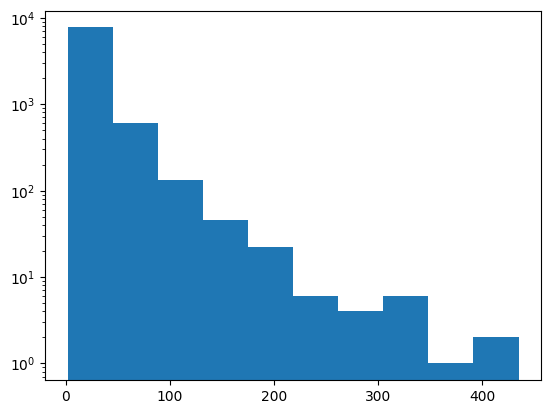

In [7]:
print("This plot show the time difference between End time - Start time of the flares.")
print(f"Time difference {df_list['StEnd'].quantile(0.75)} (min) is upper 75% quantile!")
plt.hist(df_list['StEnd'], log = True)
plt.show()

This plot show the time difference between End time of previous flare - Start time of the current flare.
Time difference 19.0 (min) is lower 10% quantile!


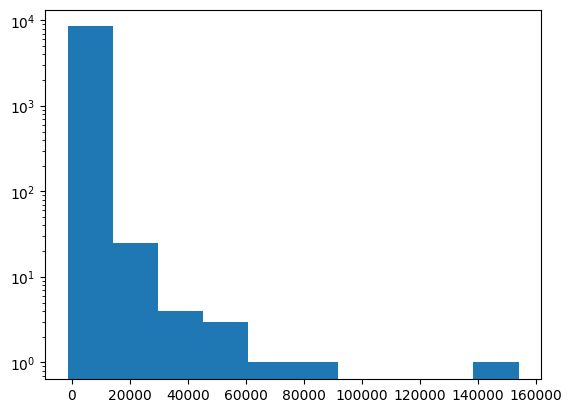

In [8]:
print("This plot show the time difference between End time of previous flare - Start time of the current flare.")
print(f"Time difference {df_list['TdiffFL'].quantile(0.10)} (min) is lower 10% quantile!")
plt.hist(df_list['TdiffFL'], log = True)
plt.show()

In [9]:
# We only take Eruptive Flare into account. 
df_er = df_list.loc[df_list['cme_vel'].notnull(), :]

In [10]:
# There are also negative X-ray flux, so these values should be removed.
df_xray.loc[df_xray['B_AVG'] < 0, :]

,Timestamp,B_AVG,B_filtered
6903,2010-01-05 19:03:00,-99999.0,NaN
8628,2010-01-06 23:48:00,-99999.0,NaN
8629,2010-01-06 23:49:00,-99999.0,NaN
8630,2010-01-06 23:50:00,-99999.0,NaN
8631,2010-01-06 23:51:00,-99999.0,NaN
...,...,...,...
4937863,2019-05-23 01:43:00,-99999.0,NaN
4937864,2019-05-23 01:44:00,-99999.0,NaN
4937865,2019-05-23 01:45:00,-99999.0,NaN
4937866,2019-05-23 01:46:00,-99999.0,NaN


In [11]:
# Check class imbalance, 500 is a current threshold.
df_er = df_er.assign(label = np.where(df_er['cme_vel'] >= 500, 1, 0))
df_er['label'].value_counts()

label
0    1329
1     941
Name: count, dtype: int64

In [14]:
df_xray.loc[df_xray['Timestamp'].between("2015-12-04 16:53:00", "2015-12-04 17:15:00"), :]

,Timestamp,B_AVG,B_filtered
3115733,2015-12-04 16:53:00,-99999.0,NaN
3115734,2015-12-04 16:54:00,-99999.0,NaN
3115735,2015-12-04 16:55:00,-99999.0,NaN
3115736,2015-12-04 16:56:00,-99999.0,NaN
3115737,2015-12-04 16:57:00,-99999.0,NaN
3115738,2015-12-04 16:58:00,-99999.0,NaN
3115739,2015-12-04 16:59:00,-99999.0,NaN
3115740,2015-12-04 17:00:00,-99999.0,NaN
3115741,2015-12-04 17:01:00,-99999.0,NaN
3115742,2015-12-04 17:02:00,-99999.0,NaN


In [16]:
1329/(941+1329)

0.5854625550660792

In [17]:
1329/941

1.412327311370882

In [18]:
 from pyts.datasets import load_gunpoint

In [19]:
 X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)

In [20]:
X_train

array([[-0.6478854 , -0.64199155, -0.63818632, ..., -0.64042873,
        -0.63866571, -0.63865722],
       [-0.64442658, -0.64540093, -0.64705511, ..., -0.6349345 ,
        -0.6344968 , -0.63159565],
       [-0.77835282, -0.77827907, -0.77715084, ..., -0.70419626,
        -0.70760524, -0.7071202 ],
       ...,
       [-0.77912617, -0.77837863, -0.7757449 , ..., -0.50500603,
        -0.50373099, -0.50438486],
       [-0.70303339, -0.70261754, -0.70250356, ..., -0.64113375,
        -0.64140622, -0.64210896],
       [-1.4357199 , -1.4322717 , -1.4329285 , ..., -1.4354619 ,
        -1.4352821 , -1.4308845 ]])

In [21]:
y_train

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1,
       2, 2, 1, 2, 1, 2])